I need to figure out a way of translating the river mouth locations to the grid from the model. 

TOC:
1. read shapefiles (Lebreton or Meijer)
2. split Point objects.
3. bin the rivers into the coastal cells
4. Cluster the rivers in N groups
5. generate initial conditions for cluster
    - save the river coord inside the cluster
    - generate delayed realease randomized
    - save them, sneaky beasts
6. Compute priors.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

import random

In [2]:
def haversine_distance_two(point_A, point_B):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    """
    lat1, lon1 = point_A
    lat2, lon2 = point_B
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


def region_filters(DF, lon_min, lon_max, lat_min, lat_max, shapefile=False):
    """
    DF is the River_sources dataframes. lat_min, lat_max, lon_min, lon_max are the domain limits.
    Returns the dataframe only for the region.
    """
    if shapefile:
        X = DF.geometry.x
        Y = DF.geometry.y
    else:
        X = DF['X']
        Y = DF['Y']
        
    mask = (X <= lon_max) & (X > lon_min) & (Y <= lat_max) & (Y > lat_min)
    
    new_DF = DF[mask]
    return new_DF
    

In [3]:
coastal_fields = xr.load_dataset('../coastal_fields.nc')

In [4]:
coast = coastal_fields.coast.values
lats = coastal_fields.lat.values
lons = coastal_fields.lon.values

X = coastal_fields.lon_mesh
Y = coastal_fields.lat_mesh

In [5]:
iy_coast, ix_coast = np.where(coast==1)
lat_coast = lats[iy_coast]
lon_coast = lons[ix_coast]

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


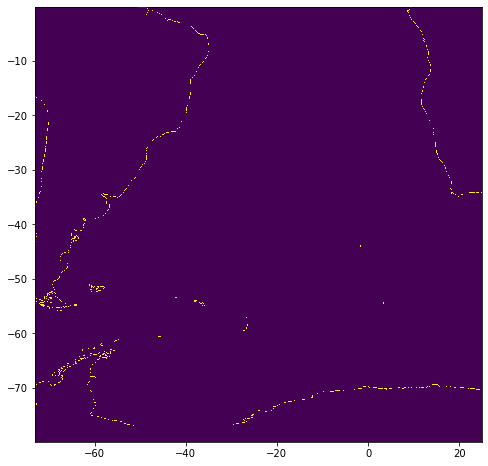

In [6]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X, Y, coast)

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


(-47.0, -43.0)

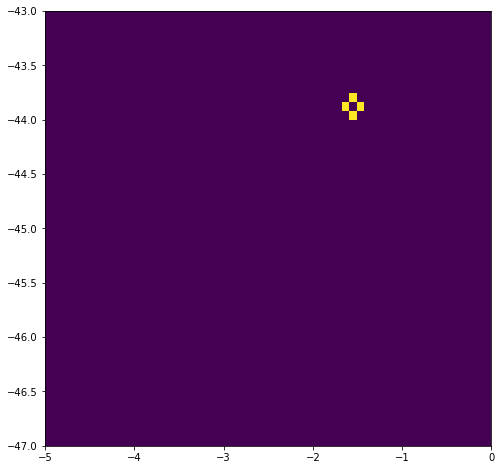

In [7]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X, Y, coast)
plt.xlim(-5,0)
plt.ylim(-47,-43)

In [18]:
def nearest_coastal_cell(latidute, longitude, coord_lat, coord_lon):    
    """
    Function to find the index of the closest point to a certain lon/lat value.
    
    latidute and longitude are the dimensinal 1D arrays of the grid, with the same length.
    coord_lat and coord_lon are the coordinates of a point.
    """
    
    distance = np.sqrt((longitude-coord_lon)**2 + (latidute-coord_lat)**2)                     
    index = distance.argmin()               
        
    return index

In [19]:
South_Atlantic_region = (-70, 25, -50, -5)

# 1. Loading data from GIS shapefiles

In [6]:
def convert_geopandas2pandas(path):
    '''Replaces the geometry column with a X and Y columns
    There no built-in function for this in geopandas! 
    '''
    geoDF = gpd.read_file(path)
    L = len(geoDF)
    coord = np.zeros((L,2))
    coord[:, 0] = geoDF.geometry.x
    coord[:, 1] = geoDF.geometry.y
    aux = pd.DataFrame(coord, columns=['X','Y'])
    geoDF.drop(columns=['geometry'], inplace=True)
    geoDF = pd.concat([geoDF, aux], axis=1)
    
    return geoDF

In [7]:
path = '../data/sources/Meijer2021_midpoint_emissions/' 
meijer = convert_geopandas2pandas(path)

In [8]:
meijer.rename(columns={'dots_exten':'emissions'}, inplace=True)

In [9]:
df = meijer.copy()

In [10]:
df['emissions'] = df['emissions']/df['emissions'].sum()

In [11]:
meijer.head()

,emissions,X,Y
0,0.164904,168.797917,-46.580833
1,0.124932,168.348750,-46.447083
2,1.213370,168.337083,-46.418750
3,0.121138,168.021250,-46.357917
4,0.197533,169.811250,-46.343750


In [12]:
meijer.to_csv('../data/sources/Meijer2021_midpoint_emissions.csv')

# 2. 

In [13]:
def rivers2coastalgrid(DF, coastal_fields):
    
    N = len(DF)
    
    coast = coastal_fields.coast.values
    lats = coastal_fields.lat.values
    lons = coastal_fields.lon.values
    iy_coast, ix_coast = np.where(coast==1)
    lat_coast = lats[iy_coast]
    lon_coast = lons[ix_coast]

    new_coordinates = np.zeros((N, 2)) 

    for i in range(N):
        x_lon = DF.iloc[i].X
        x_lat = DF.iloc[i].Y

        n_index = nearest_coastal_cell(lat_coast, lon_coast, x_lat, x_lon)
        new_coordinates[i,:] = (lon_coast[n_index], lat_coast[n_index])
        
    aux = pd.DataFrame(new_coordinates, columns=['X_bin', 'Y_bin'], index=DF.index)
    new_DF = pd.concat([DF, aux], axis=1)
    
    counts = new_DF.groupby(['X_bin', 'Y_bin']).count().loc[:, 'X'].values
    new_DF = new_DF.groupby(['X_bin', 'Y_bin']).sum()
    new_DF['merged_rivers'] = counts
    new_DF.reset_index(inplace=True)
    new_DF.drop(labels=['X', 'Y'], axis=1, inplace=True)

    return new_DF

**How many rivers from the top 1000 rivers are there in the South Atlantic?**

In [14]:
df_sort = df.sort_values(['emissions'], ascending=False)

In [15]:
df_1000 = df_sort[:1000]

In [20]:
SA_1000_share, _ = region_filters(df_1000, *South_Atlantic_region).shape

In [21]:
SA_1000_share

47

47 of the top 1000 rivers are in the South Atlantic

-----

In [22]:
sa_meijer = region_filters(meijer, *South_Atlantic_region)
sa_meijer = sa_meijer.sort_values(['emissions'], ascending=False)

In [23]:
sa_meijer.shape

(1010, 3)

In [24]:
top_47 = sa_meijer[:47]

In [25]:
binned_top_47 = len(rivers2coastalgrid(top_47, coastal_fields))

In [26]:
binned_top_47

37

In [27]:
bin_meijer = rivers2coastalgrid(sa_meijer, coastal_fields)

In [28]:
bin_meijer.shape

(535, 4)

implement a counter for the rivers merged per bin

Text(0.5, 1.0, 'Top 47 Meijer al. 2021')

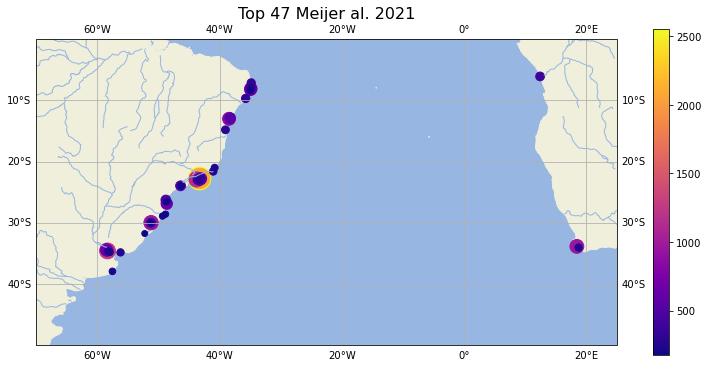

In [29]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(top_47['X'], top_47['Y'], c=top_47['emissions'],
                 s=top_47['emissions']/5, cmap='plasma', edgecolors=None)
plt.colorbar(im)
plt.title('Top 47 Meijer al. 2021', fontsize=16)

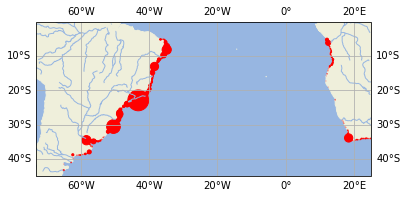

In [30]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-73, 25,-45, 0], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

#plt.pcolormesh(X, Y, coast)
im = plt.scatter(bin_meijer['X_bin'], bin_meijer['Y_bin'], c='r',
                 s=bin_meijer['emissions']/15, cmap='plasma', edgecolors=None)


In [31]:
total_SA = bin_meijer['emissions'].sum()

In [32]:
total_SA

37539.313500000004

In [33]:
sort_meijer = bin_meijer.sort_values(['emissions'], ascending=False)
sort_meijer.reset_index(inplace=True, drop=True)

In [34]:
sort_meijer

,X_bin,Y_bin,emissions,merged_rivers
0,-43.166668,-22.916666,6504.328900,8
1,-50.416668,-30.583334,2825.247684,22
2,-58.333332,-34.583332,1283.969980,3
3,-34.833332,-8.083333,1266.363000,2
4,-43.750000,-23.083334,1167.378900,2
...,...,...,...,...
530,19.666666,-34.750000,0.116729,1
531,-47.333332,-24.666666,0.114340,1
532,13.333333,-10.000000,0.114288,1
533,-39.166668,-17.083334,0.106569,1


# How to do the clustering? 

Three words: center of mass.

In [35]:
cluster_locations = {'Congo':(-5.6442, 12.1375),
                     'Cape-Town':(-33.93, 18.56),
                    'Rio-de-la-Plata':(-33.9375, -58.5208),
                    'Porto-Alegre':(-30.051, -51.285),
                    'Santos':(-23.9875, -46.2958),
                    'Paraiba':(-21.6208, -41.0375),
                    'Itajai':(-26.9125, -48.6458),
                    'Rio-de-Janeiro':(-23.01250, -43.32083),
                    'Salvador':(-13.017065, -38.579832),
                    'Recife':(-8.09, -34.88)}
# 'Luanda':(-8.82, 13.22),
#                      'Cuvo':(-10.87917, 13.81250),
grid_cluster_centers = {}
for loc in cluster_locations:

    indx = nearest_coastal_cell(lat_coast, lon_coast, *cluster_locations[loc])
    grid_cluster_centers[loc] = (lat_coast[indx], lon_coast[indx])

In [36]:
grid_cluster_centers

{'Congo': (-5.6666665, 12.083333),
 'Cape-Town': (-33.916668, 18.416666),
 'Rio-de-la-Plata': (-34.083332, -58.333332),
 'Porto-Alegre': (-30.583334, -50.416668),
 'Santos': (-24.0, -46.333332),
 'Paraiba': (-21.583334, -41.0),
 'Itajai': (-26.916666, -48.583332),
 'Rio-de-Janeiro': (-23.0, -43.333332),
 'Salvador': (-13.083333, -38.583332),
 'Recife': (-8.083333, -34.833332)}

In [37]:
sort = bin_meijer.sort_values(['emissions'], ascending=False)
sort.reset_index(inplace=True, drop=True)

No handles with labels found to put in legend.


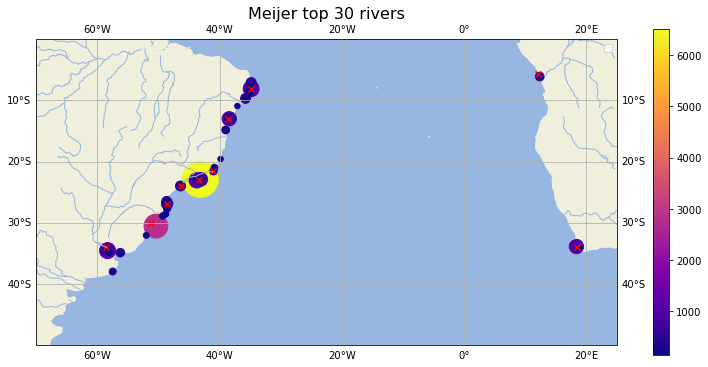

In [38]:
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent((-70, 25, -50, 0), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.RIVERS)
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

M = 47
#plt.pcolormesh(X, Y, coast)
im = plt.scatter(sort['X_bin'][:M], sort['Y_bin'][:M], c=sort['emissions'][:M],
                 s=sort['emissions'][:M]/5, cmap='plasma', edgecolors=None)

for loc in cluster_locations:
    x = cluster_locations[loc][1]
    y = cluster_locations[loc][0]
    plt.scatter(x, y, c='r', marker='x')
    
plt.colorbar(im)
plt.title('Meijer top 30 rivers', fontsize=16)
plt.legend()

In [39]:
def center_of_mass(DF):
    
    x = DF.X_bin
    y = DF.Y_bin
    m = DF.emissions #this is so annoying
    M = m.sum()
    
    return sum(m*y)/M, sum(m*x)/M

In [40]:
def rivers_per_location(DF, loc_coords, radius, binned=False, tolerance=0.1):
    """
    It cluster the rivers in a square with sides 2*radius.
    The clustering is done iteratively using the center of mass.
    Input
    - DF: the pandas Dataframe with data River_sources. 
    - loc_coords: tuple with the location coordinates as in (lat, lon).
    - radius: the radius in degrees around loc_coords.
    - tolerance: [km]
    Returns 
    - the dataframe around loc_coords.
    """
    if binned:
        _label = '_bin'
        
    else:
        _label = ''
        
    x_col = f'X{_label}'
    y_col = f'Y{_label}'
    
    lat, lon = loc_coords
    mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & \
            (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
    CM = center_of_mass(DF[mask])
    dist = haversine_distance_two((lat,lon), CM)
    
    while dist > tolerance:
        lat, lon = CM
        mask = (DF[x_col] <= lon + radius) & (DF[x_col] > lon - radius) & \
                (DF[y_col] <= lat + radius) & (DF[y_col] > lat - radius)
        CM = center_of_mass(DF[mask])
        dist = haversine_distance_two((lat,lon), CM)
    
    loc_df = DF[mask]
    p = pd.DataFrame({'p': loc_df['emissions']/loc_df['emissions'].sum()})
    loc_df = loc_df.drop(['emissions'], axis=1)
    loc_df = pd.concat([loc_df, p], axis=1)
    loc_df.reset_index(inplace=True)

    return mask, CM

In [41]:
_mask, _cm = rivers_per_location(sort, cluster_locations['Rio-de-Janeiro'], 1, binned=True)
print('CM', _cm)
print('OC', cluster_locations['Rio-de-Janeiro'])
print(haversine_distance_two(_cm, cluster_locations['Rio-de-Janeiro']))

CM (-22.945060155551058, -43.25007477878783)
OC (-23.0125, -43.32083)
10.419394448211134


Congo [12.322773940845202, 12.322773940845202, -5.839025814859182, -5.839025814859182]
Cape-Town [18.516123691832572, 18.516123691832572, -33.98071957888667, -33.98071957888667]
Rio-de-la-Plata [-58.33804718267087, -58.33804718267087, -34.533424574858756, -34.533424574858756]
Porto-Alegre [-50.42807859021225, -50.42807859021225, -30.591184442740754, -30.591184442740754]
Santos [-46.282869090631785, -46.282869090631785, -23.97941880008897, -23.97941880008897]
Paraiba [-41.149217208680454, -41.149217208680454, -21.594112104419448, -21.594112104419448]
Itajai [-48.60662095689911, -48.60662095689911, -26.95349610101432, -26.95349610101432]
Rio-de-Janeiro [-43.25007477878783, -43.25007477878783, -22.945060155551058, -22.945060155551058]
Salvador [-38.41695490351165, -38.41695490351165, -13.005334422056057, -13.005334422056057]
Recife [-34.877316798218914, -34.877316798218914, -8.117255001381881, -8.117255001381881]


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdi" which is no longer supported as of 3.3 and will become an error two minor releases later


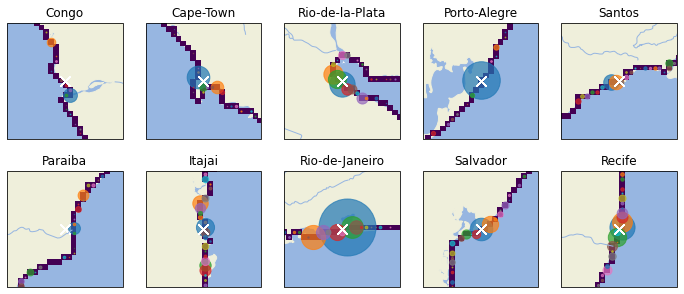

In [42]:
fig, ax = plt.subplots(ncols=5,nrows=2,figsize=(12,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

coast_mask = np.ma.masked_equal(coast, 0)


ax = np.reshape(ax, 10)

r = 1
adjusted_cluster = {}
unclustered_mask = 0


for i, loc in enumerate(cluster_locations):
    
    loc_mask, loc_CM = rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    unclustered_mask = unclustered_mask | loc_mask
    adjusted_cluster[loc] = loc_CM
    
    lat_BA, lon_BA = loc_CM 
    loc_df = sort[loc_mask]
    print(loc, [lon_BA, lon_BA, lat_BA, lat_BA])
    ax[i].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.OCEAN)
    ax[i].add_feature(cfeature.LAND)
#     ax[i].add_feature(cfeature.COASTLINE)
    ax[i].add_feature(cfeature.RIVERS)
    ax[i].set_title(loc)
    ax[i].pcolormesh(X, Y, coast_mask)
#     g1 = ax[i].gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,
#             color='black', linestyle='--', alpha=0.1)
#     g1.top_labels = False
#     g1.right_labels = False

    
    for m in loc_df.index:
        ax[i].scatter(loc_df['X_bin'][m], loc_df['Y_bin'][m], s=loc_df['emissions'][m]*0.5,
                     alpha=0.7)
#         ax[i].scatter(cluster_locations[loc][1], cluster_locations[loc][0], c='white',
#                       marker='s',  edgecolor='k', s=100)
        ax[i].scatter(loc_CM[1], loc_CM[0], c='white', marker='x', edgecolor='k', s=100)

plt.savefig('../article_figs/release_locations', pdi=130)

In [43]:
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'sans-serif'

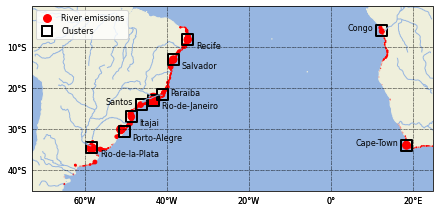

In [45]:
fig,ax = plt.subplots(figsize=(6,4),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-73, 25,-45, 0], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=0)
im = ax.scatter(sa_meijer['X'], sa_meijer['Y'], c='r',
                 s=sa_meijer['emissions']/15, edgecolors=None)
    
    
Sudamerica = ['Itajai', 'Rio-de-la-Plata',
              'Porto-Alegre','Recife', 'Salvador', 'Rio-de-Janeiro',]
for loc in Sudamerica:
    ax.scatter(adjusted_cluster[loc][1], adjusted_cluster[loc][0], 
               s=120, marker='s', linewidths=2, edgecolors='k', facecolor="None",
              label='Cluster')
    ax.text(adjusted_cluster[loc][1]+2, adjusted_cluster[loc][0]-2, s=loc,
           fontsize=8)
    
annoying = ['Paraiba']

for loc in annoying:
    ax.scatter(adjusted_cluster[loc][1], adjusted_cluster[loc][0], 
               s=120, marker='s', linewidths=2, edgecolors='k', facecolor="None",
              label='Cluster')
    ax.text(adjusted_cluster[loc][1]+2, adjusted_cluster[loc][0]+0, s=loc,
           fontsize=8)

Africa = ['Congo', 'Cape-Town', 'Santos']
for loc in Africa:
    ax.scatter(adjusted_cluster[loc][1], adjusted_cluster[loc][0], 
               s=120, marker='s', linewidths=2, edgecolors='k', facecolor="None",
              label='Cluster')
    ax.text(adjusted_cluster[loc][1]-2, adjusted_cluster[loc][0], s=loc,
           fontsize=8, ha='right')


legend_elements = [Line2D([0], [0], marker='o', color='w', label='River emissions',
                          markerfacecolor='r', markersize=10),
                    Line2D([0], [0], marker='s', color='w', label='Clusters',
                          markerfacecolor='w', markeredgecolor='k', markeredgewidth=2, markersize=10)]

ax.legend(handles=legend_elements, loc='upper left',
         fontsize=8)

# plt.savefig('../article_figs/clusters.pdf', format='pdf')
plt.savefig('../article_figs/clusters.jpg', format='jpg', dpi=300)

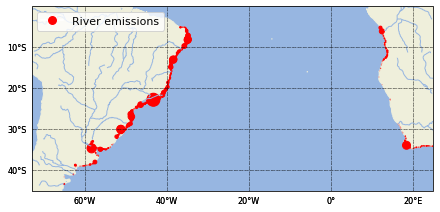

In [45]:
fig,ax = plt.subplots(figsize=(6,4),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-73, 25,-45, 0], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN)

ax.add_feature(cfeature.LAND, zorder=0)
im = ax.scatter(sa_meijer['X'], sa_meijer['Y'], c='r',
                 s=sa_meijer['emissions']/15, edgecolors=None)

legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label='River emissions',
                          markerfacecolor='r', markersize=10)]

ax.legend(handles=legend_elements, loc='upper left',
         fontsize=11)
    
plt.savefig('../article_figs/sa_rivers.png', dpi=200)

In [48]:
release_points = {}
river_positions = {}
priors = {}
r = 1.5
N = 100000 #Number of particles realesed pre source.

cluster_percent = 0
merged_rivers = 0

adjusted_cluster = {}
total_realse_loc = 0
unclustered_mask = 0

for i, loc in enumerate(cluster_locations):
    
    _mask, _CM = rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    unclustered_mask = unclustered_mask | _mask
    
    adjusted_cluster[loc] = _CM
    lat_BA, lon_BA = _CM 
    loc_df = sort[_mask]
    print(loc, len(loc_df))
    total_realse_loc += len(loc_df)
    
    loc_percent = loc_df['emissions'].sum()/total_SA
    no_rivers = loc_df['merged_rivers'].sum()
    merged_rivers += no_rivers
    priors[loc] = [loc_percent, no_rivers]
    cluster_percent += loc_df['emissions'].sum()/total_SA
    p = pd.DataFrame({'p': loc_df['emissions']/loc_df['emissions'].sum()})
    
    loc_df = loc_df.drop(['emissions'], axis=1)
    loc_df = pd.concat([loc_df, p], axis=1)
    loc_df.reset_index(drop=True, inplace=True)
    
    river_positions[loc] = loc_df
    release_points[loc] = loc_df.sample(n=N, replace=True, weights='p')
    
unclustered_mask = ~unclustered_mask
# no_rivers = unclustered['merged_rivers'].sum()
# priors['Other'] = [1 - cluster_percent, no_rivers]
# priors = pd.DataFrame(priors).T
# priors = priors.rename(columns={0:'mean', 1:'merged_rivers'})
# # priors.to_csv('../data/analysis/river_input_analysis.csv')

# total_realse_loc

Congo 19
Cape-Town 22
Rio-de-la-Plata 30
Porto-Alegre 19
Santos 30
Paraiba 34
Itajai 33
Rio-de-Janeiro 35
Salvador 27
Recife 34


In [49]:
priors

{'Congo': [0.01621288066442664, 25],
 'Cape-Town': [0.04238327413739198, 36],
 'Rio-de-la-Plata': [0.09846875265846297, 61],
 'Porto-Alegre': [0.08277577002040812, 65],
 'Santos': [0.046162844480360565, 77],
 'Paraiba': [0.037891777962322085, 56],
 'Itajai': [0.07522477087920107, 127],
 'Rio-de-Janeiro': [0.2848324175400809, 83],
 'Salvador': [0.06794850228148151, 65],
 'Recife': [0.1270644209037014, 69]}

In [61]:
unclustered = sort[unclustered_mask]

unclustered_percent = unclustered['emissions'].sum()/total_SA

p = pd.DataFrame({'p': unclustered['emissions']/unclustered['emissions'].sum()})
    
unclustered = unclustered.drop(['emissions'], axis=1)
unclustered = pd.concat([unclustered, p], axis=1)
unclustered.reset_index(drop=True, inplace=True)
# river_positions['Unclustered'] = unclustered

unclustered_africa = unclustered[unclustered['X_bin'] > 0]
unclustered_america = unclustered[unclustered['X_bin'] < 0]

release_points['Unclustered'] = unclustered.sample(n=N, replace=True, weights='p')

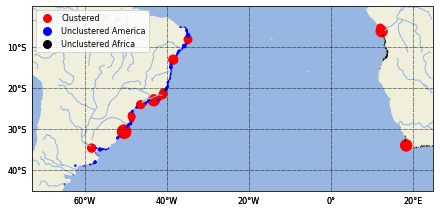

In [66]:
fig,ax = plt.subplots(figsize=(6,4),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-73, 25,-45, 0], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=0)

for loc in river_positions.keys():
    df = river_positions[loc]
    
    ax.scatter(df['X_bin'], df['Y_bin'], c='r',
                   s=df['p']*200, edgecolors=None)
    
ax.scatter(unclustered_africa['X_bin'], unclustered_africa['Y_bin'], c='k',
                   s=unclustered_africa['p']*200, edgecolors=None)

ax.scatter(unclustered_america['X_bin'], unclustered_america['Y_bin'], c='b',
                   s=unclustered_america['p']*200, edgecolors=None)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Clustered', markerfacecolor='r', markersize=10),
                  Line2D([0], [0], marker='o', color='w', 
                         label='Unclustered America', markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', 
                         label='Unclustered Africa', markerfacecolor='k', markersize=10)]
    
ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.savefig('../article_figs/clusters&uncluesterd.pdf', format='pdf')

In [164]:
release_points['Unclustered']

,X_bin,Y_bin,merged_rivers,p
0,-34.833332,-7.083333,2,0.071108
17,-40.333332,-20.416666,1,0.015753
214,-58.250000,-38.500000,2,0.000125
71,-65.000000,-43.333332,1,0.002439
1,-35.750000,-9.666667,2,0.067475
...,...,...,...,...
18,-49.166668,-28.833334,2,0.015704
16,-35.166668,-5.916667,2,0.017915
1,-35.750000,-9.666667,2,0.067475
40,-35.000000,-6.333333,1,0.005628


In [102]:
unclustered['emissions'].sum()/total_SA

0.19079363385268083

In [98]:
unclustered_mask.sum()

334

In [93]:
len(unclustered_mask) - unclustered_mask.sum()

201

In [45]:
priors

,mean,merged_rivers
Congo,0.016213,25.0
Cape-Town,0.042383,36.0
Rio-de-la-Plata,0.098469,61.0
Porto-Alegre,0.082776,65.0
Santos,0.046163,77.0
Paraiba,0.037892,56.0
Itajai,0.075225,127.0
Rio-de-Janeiro,0.284832,83.0
Salvador,0.067949,65.0
Recife,0.127064,69.0


In [48]:
release_points['Congo'].shape

(100000, 4)

Congo (535,)
Cape-Town (535,)
Rio-de-la-Plata (535,)
Porto-Alegre (535,)
Santos (535,)
Paraiba (535,)
Itajai (535,)
Rio-de-Janeiro (535,)
Salvador (535,)
Recife (535,)


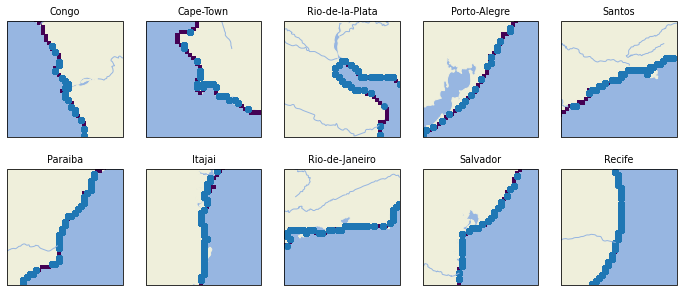

In [65]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(12,5),
                      subplot_kw={'projection': ccrs.PlateCarree()})

coast_mask = np.ma.masked_equal(coast, 0)

ax = np.reshape(ax, 10)
r = 1.5

for i, loc in enumerate(cluster_locations):
    
    loc_mask, loc_CM= rivers_per_location(sort, cluster_locations[loc], r, binned=True)
    print(loc, loc_mask.shape)
    lat_BA, lon_BA = loc_CM 
#     loc_df = sort[loc_mask]
    
    ax[i].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.OCEAN)
    ax[i].add_feature(cfeature.LAND)
    ax[i].add_feature(cfeature.RIVERS)
    ax[i].set_title(loc)
    ax[i].pcolormesh(X, Y, coast_mask)
    ax[i].scatter(release_points[loc]['X_bin'], release_points[loc]['Y_bin'])


/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdi" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


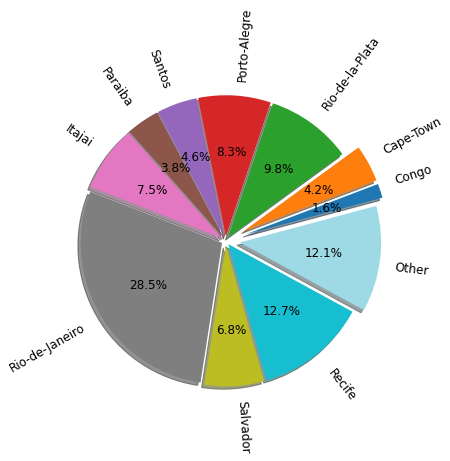

In [48]:
x_colors = np.linspace(0, 1, 11)
cs = cm.get_cmap('tab20')(x_colors)

plt.figure(figsize=(7,6.5))
wedgeprops = {'fontsize': 12}

explode = [0.15, 0.15, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.1]

plt.pie(priors['mean'], labels=priors.index, autopct='%.1f%%',
       shadow=True, explode=explode, colors=cs,
       rotatelabels=True, startangle=15, textprops=wedgeprops);

plt.savefig('../article_figs/proportions.png', pdi=130)

In [61]:
priors_true = pd.read_csv('../data/analysis/priors_river_inputs.csv', index_col=0)

/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdi" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


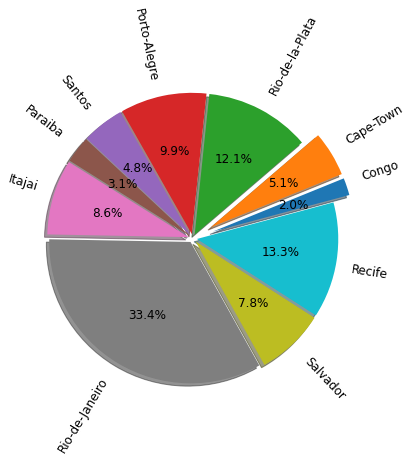

In [64]:
x_colors = np.linspace(0, 1, 11)
cs = cm.get_cmap('tab20')(x_colors)

plt.figure(figsize=(7,6.5))
wedgeprops = {'fontsize': 12}

explode = [0.15, 0.15, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]

plt.pie(priors_true['Mean'], labels=priors.index, autopct='%.1f%%',
       shadow=True, explode=explode, colors=cs,
       rotatelabels=True, startangle=15, textprops=wedgeprops);

plt.savefig('../article_figs/priors.png', pdi=130)

In [59]:
print(priors.to_latex())

\begin{tabular}{lrr}
\toprule
{} &      Mean &  merged\_rivers \\
\midrule
Congo           &  0.019756 &           22.0 \\
Cape-Town       &  0.051432 &           34.0 \\
Rio-de-la-Plata &  0.120597 &           51.0 \\
Porto-Alegre    &  0.098673 &           49.0 \\
Santos          &  0.048234 &           55.0 \\
Paraiba         &  0.030517 &           32.0 \\
Itajai          &  0.086101 &           91.0 \\
Rio-de-Janeiro  &  0.333884 &           50.0 \\
Salvador        &  0.078250 &           57.0 \\
Recife          &  0.132556 &           45.0 \\
\bottomrule
\end{tabular}



In [60]:
A = np.load('../release_positions.npy', allow_pickle=True).item()

In [62]:
A['Congo']

,X_bin,Y_bin,merged_rivers,p
0,12.416667,-6.083333,1,0.635873
0,12.416667,-6.083333,1,0.635873
7,12.583333,-6.666667,1,0.004596
0,12.416667,-6.083333,1,0.635873
4,12.416667,-6.000000,2,0.021469
...,...,...,...,...
1,12.083333,-5.166667,2,0.246447
0,12.416667,-6.083333,1,0.635873
0,12.416667,-6.083333,1,0.635873
0,12.416667,-6.083333,1,0.635873


In [64]:
535*0.872

466.52